### Exploring Spatial Dynamics of Dog Ownership in Zurich

#### Problem Statement (Hypothesis Formation):
How can we strategically leverage data on dog owners in Zurich, population demographics, income levels, and household sizes across its 34 neighborhoods to gain insights into dog ownership patterns, predict future trends, and provide actionable recommendations for stakeholders?

#### Context:
The city of Zurich is embarking on a comprehensive exploration of dog ownership dynamics within its neighborhoods. This initiative responds to a gradual shift in popularity from larger to smaller breed dogs, coupled with a noticeable uptick in pet dog ownership since the removal of mandatory dog training course requirements in 2017. The city's objectives are to inform urban planning, support pet service businesses, and enhance the overall well-being of residents and their pets. Our analysis focuses on uncovering spatial patterns, identifying factors influencing dog ownership, and offering predictive insights for future planning.

#### Criteria for Success:
The project will be considered successfully completed when the predictive models consistently achieve a Mean Absolute Error (MAE) below 10% in forecasting the number of dog owners in Zurich's 34 neighborhoods for 2021.

#### Constraints within Solution Space:
- **Breed Consideration:** The analysis will consider data for pure breed dogs, excluding mix breed dogs to avoid potential confusions and complexities. May come back to mix breeds after or use it if we are considering dogs in general.
- **Temporal Constraints:** The analysis and modeling efforts are constrained to the overlapping years of the datasets which are from 2015 to 2020.

#### Stakeholders:
- **City Planners:** Interested in understanding spatial patterns to inform urban planning policies.
- **Businesses:** Seeking insights for marketing strategies and service offerings related to pet services.
- **Local Authorities:** Interested in enhancing the well-being of residents and their pets through informed decisions.
- **Pet Owners:** Seeking insights to ensure puppies can socialize effectively, and dogs receive appropriate contact and care.

#### Key Data Sources:
- **Geometry Data:** [Link to Geometry Data](https://data.stadt-zuerich.ch/dataset/geo_statistische_quartiere)
- **Dog Owners Data:** [Link to Dog Owners Data](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv)
- **Population Data:** [Link to Population Data](https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv)
- **Income Data:** [Link to Income Data](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv)
- **Household Data:** [Link to Household Data](https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv)

These combined data sources will serve as the foundation for our spatial data science analysis, providing insights into dog ownership patterns, demographics, income levels, and household sizes across Zurich's neighborhoods.


THese are reminders in case youforget what you are tryin gto do
Spatial Analysis of Dog Ownership in Zurich
Dog ownership density


- examine the dynamic interplay between demographic factors, such as population density, household size, and income level, with the prevalence of dog ownership. 
- uncover trends, identify business opportunities in the pet dog services sector, and offer tailored, data-driven insights for businesses in each neighborhood.

ideas

- Understand the current distribution of dog breeds across Zurich's neighborhoods.
- Apply predictive modeling to forecast changes in the distribution of dog breeds.
- identify spatial clusters and patterns of high or low concentrations of dog owners
- Identify localized patterns using spatial analysis techniques like LISA (Local Indicators of Spatial Association).
- Provide recommendations for businesses, urban planners, and policymakers based on spatial insights.
- Identify trending dog ownership patterns
- correlate population demographics with dog ownership
- Income level influence on dog ownership
- Spatial analysis on dog ownership
- Predictive trends such as rising popularity of certain breeds




### Imports & Configurations

This section includes the necessary imports for libraries, configuration settings for dataframes and visualizations These components establish the foundational setup for subsequent data analysis and exploration. 


In [1]:
import re
from typing import Optional, Callable
from pathlib import Path
from pprint import pprint
from urllib.request import urlopen
from fiona.io import ZipMemoryFile
import numpy as np
import pandas as pd
import geopandas as gpd
import geoviews as gv
import geoviews.tile_sources as gvts
from thefuzz import fuzz
import hvplot
import hvplot.pandas
import holoviews as hv
from holoviews import streams
import colorcet as cc
import cartopy.crs as ccrs
import panel as pn
import panel.widgets as pnw
import seaborn as sns
from wordcloud import WordCloud
from PIL import ImageDraw, Image
from IPython.display import clear_output

from translate_app import translate_list_to_dict
import helper_functions as hf

In [2]:
# suppress warnings
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
gv.extension("bokeh")
hv.extension("bokeh")
hvplot.extension("bokeh")
pn.extension()

pn.config.throttled = True

clear_output()  # clear the blank lines output from holoviews

#### Column Name Transformation

To enhance readability and ensure consistency, the original column names in the various datasets have been translated from german to english and converted to snake case using our `sanitize_df_column_names` helper function. This transformation results in a cleaner and more standardized DataFrame, making the data easier to work with. 


#### Zurich Statistical Districts Geospatial Data

The city of Zurich is divided into 34 statistical districts, derived from the 12 districts or 22 urban districts. These statistical divisions serve the purpose of spatially differentiating statistical data for administrative tasks within the City of Zurich departments. The divisions are essential for internal administrative functions and contribute to the organization and analysis of statistical information.

The geospatial data for Zurich's statistical districts is organized into a dictionary with abbreviated and standardized keys for enhanced clarity and brevity. The keys now follow a systematic structure:

- `z_gdf_0`: Point data optimized for optimal label positioning on maps.
- `z_gdf_1`: Geospatial data tailored for data visualization and cartographic representations.
- `z_gdf_2`: Geospatial data specifically designed for calculating area information or spatial intersections.

The organizational structure allows for efficient handling and analysis of the geospatial information.



In [3]:
zip_gdf_url = "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_statistical_quarters.zip"
zurich_geo_dicts = hf.get_gdf_from_zip_url(zip_gdf_url)
zurich_desc_path = "../data/zurich_districts.csv"
# small dataframe with a description of each district
zurich_desc = pd.read_csv(zurich_desc_path).drop(columns=["desc_length"])
z_gdf = hf.rename_keys(zurich_geo_dicts, prefix="z_gdf_")

In [4]:
zurich_desc

,district_name,desc,district
0,"Old Town, City Center",The most central district encompasses the hist...,1
1,Left Shore of the Lake,The architecturally attractive Enge Train Stat...,2
2,Creative Quarter of Wiedikon,"Once mainly a working-class neighborhood, the ...",3
3,Creative Quarter of Langstrasse,The district around Langstrasse was long regar...,4
4,Creative Quarter of Zürich-West,In the quarter where huge machines once clatte...,5
5,University Quarter,"University buildings, Jugendstil villas, green...",6
6,On the Zürichberg,"The hillside location, little traffic, and fab...",7
7,Right Shore of the Lake,This district starts behind the Opera House an...,8
8,At the Foot of the Uetliberg,"For a long time, this district was solely know...",9
9,Right of the Limmat,This district boasts a fantastic location: in ...,10


In [5]:
# Look at the data for each of the geodataframes
z_gdf["z_gdf_0"].info()
z_gdf["z_gdf_0"].sample(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objid     34 non-null     object  
 2   name      34 non-null     object  
 3   kuerzel   34 non-null     object  
 4   ori       34 non-null     int64   
 5   hali      34 non-null     object  
 6   vali      34 non-null     object  
dtypes: geometry(1), int64(1), object(5)
memory usage: 2.0+ KB


,geometry,objid,name,kuerzel,ori,hali,vali
10,POINT (8.51485 47.38972),11,Escher Wyss,52,0,1,2
30,POINT (8.55493 47.35955),31,Mühlebach,82,0,1,2
19,POINT (8.52753 47.37158),20,Werd,41,0,1,2


In [6]:
z_gdf["z_gdf_1"].info()
z_gdf["z_gdf_1"].sample(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objectid  34 non-null     int64   
 2   objid     34 non-null     object  
 3   qnr       34 non-null     int64   
 4   qname     34 non-null     object  
 5   knr       34 non-null     int64   
 6   kname     34 non-null     object  
dtypes: geometry(1), int64(3), object(3)
memory usage: 2.0+ KB


,geometry,objectid,objid,qnr,qname,knr,kname
0,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ...",1,34,73,Hirslanden,7,Kreis 7
13,"POLYGON ((8.51810 47.34425, 8.51807 47.34433, ...",6,29,23,Leimbach,2,Kreis 2
16,"POLYGON ((8.51753 47.38535, 8.51745 47.38537, ...",12,26,42,Langstrasse,4,Kreis 4


In [7]:
z_gdf["z_gdf_2"].info()
z_gdf["z_gdf_2"].sample(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  34 non-null     geometry
 1   objid     34 non-null     object  
 2   qnr       34 non-null     int64   
 3   qname     34 non-null     object  
 4   knr       34 non-null     int64   
 5   kname     34 non-null     object  
dtypes: geometry(1), int64(2), object(3)
memory usage: 1.7+ KB


,geometry,objid,qnr,qname,knr,kname
19,"POLYGON ((8.52633 47.40990, 8.52653 47.40974, ...",27,115,Oerlikon,11,Kreis 11
32,"POLYGON ((8.55843 47.41305, 8.55844 47.41301, ...",8,121,Saatlen,12,Kreis 12
12,"POLYGON ((8.54866 47.37709, 8.54876 47.37687, ...",20,71,Fluntern,7,Kreis 7


##### Zurich Statistical Districts Geospatial Data Transformation

The Zurich geospatial data has undergone a transformation, aligning with a more comprehensive and understandable structure. Key modifications include:

- **Column Renaming:**
  - `qname` is now `neighborhood`
  - `qnr` is now `sub_district`
  - `knr` is now `district`

- **Data Type Adjustments:**
  - `sub_district` has been formatted as a string with leading zeros for consistency.

- **Selection of Relevant Columns:**
  - A refined geodataframe, `neighborhood_gdf`, retains only the essential columns: `neighborhood`, `sub_district`, `district`, and `geometry`.

- **Coordinate Reference System (CRS):**
  - The CRS information confirms the geodataframe's coordinate reference system as WGS 84 (EPSG:4326), providing geodetic latitude and longitude.


The resulting geodataframe, `neighborhood_gdf`, now presents a streamlined and structured representation of Zurich's statistical districts, ready for further analysis and interpretation.

In [8]:
zurich_map_gdf = z_gdf["z_gdf_1"]

zurich_map_gdf.rename(
    columns={"qname": "neighborhood",
             "qnr": "sub_district", "knr": "district"},
    inplace=True,
)
zurich_map_gdf["sub_district"] = zurich_map_gdf["sub_district"].astype(
    str).str.zfill(3)

# Create the refined geodataframe
neighborhood_gdf = zurich_map_gdf[
    ["neighborhood", "sub_district", "district", "geometry"]
].copy()

# Display geodataframe information and CRS
neighborhood_gdf.info()
display(neighborhood_gdf.crs)

# Display a sample entry from the transformed geodataframe
neighborhood_gdf.sample().T

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   neighborhood  34 non-null     object  
 1   sub_district  34 non-null     object  
 2   district      34 non-null     int64   
 3   geometry      34 non-null     geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.2+ KB


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,32
neighborhood,Schwamendingen-Mitte
sub_district,122
district,12
geometry,"POLYGON ((8.5876960494 47.4079702563, 8.587730..."


In [9]:
# Load the geospatial data for calculation
zurich_calc_gdf = z_gdf["z_gdf_2"]

# Calculate area in square meters and add as a new column
zurich_calc_gdf["area_km2"] = zurich_calc_gdf.to_crs(
    ccrs.GOOGLE_MERCATOR).area / 1e6

# Rename the column for consistency with the main geodataframe
zurich_calc_gdf = zurich_calc_gdf.rename(columns={"qname": "neighborhood"})

# Merge calculated features with the main geodataframe (neighborhood_gdf)
merged_gdf = neighborhood_gdf.merge(
    zurich_calc_gdf[["neighborhood", "area_km2"]], on="neighborhood"
)

# Display a snapshot of the merged geodataframe
print(merged_gdf[["neighborhood", "area_km2"]].head())

  neighborhood  area_km2
0   Hirslanden  4.764150
1      Weinegg  3.800616
2    Mühlebach  1.391885
3      Seefeld  5.273544
4         Werd  0.658930


In [10]:
poly_opts = dict(
    width=500,
    height=500,
    color_index=None,
    xaxis=None,
    yaxis=None,
)
# Neighborhood polygons
neighborhood_poly = gv.Polygons(merged_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="skyblue",
    line_width=2,
    fill_color="lightgray",
    fill_alpha=0,
)
# add a basemap
basemap = gv.tile_sources.CartoLight().opts(alpha=0.5, bgcolor="black")

In [11]:
districts_gdf = (
    neighborhood_gdf.drop(columns=["neighborhood", "sub_district"])
    .dissolve(by="district")
    .reset_index()
)
districts_gdf = districts_gdf.dissolve(by="district").reset_index()
# District polygons
districts_poly = gv.Polygons(districts_gdf.merge(zurich_desc)).opts(
    **poly_opts,
    line_color="pink",
    fill_alpha=0.02,
    tools=["tap", "box_select"],
    line_width=3
)

district_neighborhoods = (basemap * neighborhood_poly * districts_poly).opts(
    title="Zurich Districts and Neighborhoods"
)
pn.state.kill_all_servers()

pn.pane.HoloViews(district_neighborhoods)

BokehModel(combine_events=True, render_bundle={'docs_json': {'8500658c-c378-44d2-a587-7142b00b23d7': {'version…

#### Zurich Dogs Dataset
In this dataset you will find information on dogs and their owners from the owners of the municipal dog register since 2015. In the case of dog owners, information on the age group, gender and statistical neighbourhood of the place of residence is provided. For each dog, the breed, the breed type, the sex, the year of birth, the age and the color is recorded. The dog register is maintained by the Dog Control Department of the Zurich City Police.

According to the law on the keeping of dogs, the city police are obliged to keep a register of dogs kept in the city of Zurich. Every dog over the age of three months must be registered at the dog control by the owner in person or by means of the registration form.


In [12]:
zurich_dog_data_link = "https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv"
zurich_dog_data_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_dogs.csv"
)
zurich_dog_data = pd.read_csv(zurich_dog_data_link)
# zurich_dog_data.info()

In [13]:
zurich_dog_data = hf.sanitize_df_column_names(zurich_dog_data)
zurich_dog_data.info()
zurich_dog_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70967 entries, 0 to 70966
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   deadline_date_year       70967 non-null  int64 
 1   data_status_cd           70967 non-null  object
 2   holder_id                70967 non-null  int64 
 3   age_v_10_cd              70967 non-null  int64 
 4   age_v_10_long            70967 non-null  object
 5   age_v_10_sort            70967 non-null  int64 
 6   sex_cd                   70967 non-null  int64 
 7   sex_long                 70967 non-null  object
 8   sex_sort                 70967 non-null  int64 
 9   circle_cd                70967 non-null  int64 
 10  circle_lang              70967 non-null  object
 11  circle_sort              70967 non-null  int64 
 12  quar_cd                  70967 non-null  int64 
 13  quar_lang                70967 non-null  object
 14  quar_sort                70967 non-nul

,deadline_date_year,data_status_cd,holder_id,age_v_10_cd,age_v_10_long,age_v_10_sort,sex_cd,sex_long,sex_sort,circle_cd,circle_lang,circle_sort,quar_cd,quar_lang,quar_sort,race_1_text,race_2_text,breed_mixed__breed_cd,breed_mongrel_long,breed_mixed__breed_sort,breed_type_cd,breed_type_long,breed__type_sort,birth_dog_year,age_v_dog_cd,age_v_dog_long,age_v_dog_sort,sex_dog_cd,sex_dog_long,sex_dog_sort,dog_color_text,number_of_dogs
46280,2021,D,105343,50,50- bis 59-Jährige,6,2,weiblich,2,11,Kreis 11,11,111,Affoltern,111,Chihuahua,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2020,0,0-Jährige,0,2,weiblich,2,weiss/beige,1
20479,2017,D,132642,30,30- bis 39-Jährige,4,2,weiblich,2,11,Kreis 11,11,119,Seebach,119,Pudel,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2016,0,0-Jährige,0,1,männlich,1,rot,1
43042,2020,D,148398,20,20- bis 29-Jährige,3,1,männlich,1,2,Kreis 2,2,24,Enge,24,Labrador,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2018,1,1-Jährige,1,2,weiblich,2,Fox/Red,1



This data set includes many columns, some of which are redundant. Out of the 31 columns, we have selected the following 18 for our analysis.

 - deadline_date_year 
 <!-- - data_status_cd -->
 - holder_id 
 - age_v_10_cd 
 <!-- - age_v_10_long -->
 <!-- - age_v_10_sort  -->
 - sex_cd 
 <!-- - sex_long -->
 <!-- - sex_sort  -->
 - circle_cd 
 <!-- - circle_lang -->
 <!-- - circle_sort  -->
 - quar_cd 
 - quar_lang
 <!-- - quar_sort  -->
 - race_1_text
 - race_2_text
 - breed_mixed__breed_cd 
 - breed_mongrel_long
 - breed_mixed__breed_sort 
 - breed_type_cd
 <!-- - breed_type_long -->
 <!-- - breed__type_sort  -->
 - birth_dog_year 
 - age_v_dog_cd 
 <!-- - age_v_dog_long -->
 <!-- - age_v_dog_sort  -->
 - sex_dog_cd 
 <!-- - sex_dog_long -->
 <!-- - sex_dog_sort  -->
 - dog_color_text
 - number_of_dogs

##### Data Transformation and Feature Engineering

Before diving into the transformation process, let's explore some key aspects of the Zurich Dogs Dataset to understand its structure and characteristics.


In [14]:
columns_to_keep = [
    "deadline_date_year",
    "holder_id",
    "age_v_10_cd",
    "sex_cd",
    "circle_cd",
    "quar_cd",
    "quar_lang",
    "race_1_text",
    "race_2_text",
    "breed_mixed__breed_cd",
    "breed_mongrel_long",
    "breed_mixed__breed_sort",
    "breed_type_cd",
    "birth_dog_year",
    "age_v_dog_cd",
    "sex_dog_cd",
    "dog_color_text",
    "number_of_dogs",
]
zurich_dog_data = zurich_dog_data[columns_to_keep]
zurich_dog_data_descriptive_stats = zurich_dog_data.describe(include="all")

zurich_dog_data_descriptive_stats.T.sort_values(by="unique")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
breed_mongrel_long,70967,4,Rassehund,50711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
breed_type_cd,70967,4,K,43676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quar_lang,70967,40,Altstetten,5548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race_2_text,70967,176,Keine,50711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dog_color_text,70967,214,schwarz,7519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race_1_text,70967,394,Unbekannt,9095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deadline_date_year,70967.0,NaN,NaN,NaN,2019.284823,2.599858,2015.0,2017.0,2019.0,2022.0,2023.0
holder_id,70967.0,NaN,NaN,NaN,116418.268125,27013.732289,126.0,91671.0,119364.0,137444.0,163277.0
age_v_10_cd,70967.0,NaN,NaN,NaN,47.803965,56.025737,10.0,30.0,40.0,60.0,999.0
sex_cd,70967.0,NaN,NaN,NaN,1.69018,0.462423,1.0,1.0,2.0,2.0,2.0


A few things stand out here. Looking at the `dog_age` we have an extremely low minimum value which is most likely due to error input we also have an extremely high max value which may be also an error. 
the `district` Value also has a high Max number but that may be due to a placeholder for unknown values as we know we only have 12 districts. For categorical values we can see that the `breed_type` also contains some extra values. Only have three breed types instead of 4. finally for the `neighborhood` or `sub_district` columns we know that we only have 34 neighborhoods so therefore the value of 40 includes some extra values which need to be corrected

In [15]:
# Define a list of conditions and corresponding columns to be updated
conditions = [
    (zurich_dog_data["age_v_10_cd"] > 200, "age_v_10_cd"),
    (zurich_dog_data["circle_cd"] > 12, "circle_cd"),
    (zurich_dog_data["birth_dog_year"] > 2100, "birth_dog_year"),
    (zurich_dog_data["age_v_dog_cd"] > 30, "age_v_dog_cd"),
    (zurich_dog_data["breed_type_cd"] == "UN", "breed_type_cd"),
    (
        (zurich_dog_data["quar_cd"] % 10 == 0) | (
            zurich_dog_data["quar_cd"] > 200),
        "quar_cd",
    ),
    (
        (zurich_dog_data["quar_cd"] % 10 == 0) | (
            zurich_dog_data["quar_cd"] > 200),
        "quar_lang",
    ),
]

# Iterate over the conditions and columns and update the DataFrame
for condition, column in conditions:
    if column == "breed_type_cd":
        zurich_dog_data.loc[condition, column] = "K"
    elif column == "quar_lang":
        zurich_dog_data.loc[condition, column] = ""
    else:
        zurich_dog_data.loc[condition, column] = np.nan

# Check the number of NaN values in each column
zurich_dog_data.isna().sum()

deadline_date_year           0
holder_id                    0
age_v_10_cd                226
sex_cd                       0
circle_cd                    4
quar_cd                     18
quar_lang                    0
race_1_text                  0
race_2_text                  0
breed_mixed__breed_cd        0
breed_mongrel_long           0
breed_mixed__breed_sort      0
breed_type_cd                0
birth_dog_year               8
age_v_dog_cd                 8
sex_dog_cd                   0
dog_color_text               0
number_of_dogs               0
dtype: int64

In [16]:
# drop all rows with nan if they are less than 20
zurich_dog_data = zurich_dog_data.dropna(
    subset=["birth_dog_year", "quar_cd", "circle_cd"]
)

##### Breed and Mixed Type Transformation

In this step, we analyze and transform columns related to dog breeds and mixed types. This includes handling mixed breed categories and creating additional features for analysis.


In [17]:
# Unique values for "breed_mongrel_long"
breed_cat_list_de = zurich_dog_data["breed_mongrel_long"].unique().tolist()
print("Breed Categories (German):")
pprint(breed_cat_list_de, indent=4)

# Create a dictionary for translation
breed_cat_dict = translate_list_to_dict(breed_cat_list_de)
print("\nBreed Category Dictionary (Translation):")
pprint(breed_cat_dict, indent=4)

Breed Categories (German):
[   'Rassehund',
    'Mischling, beide Rassen bekannt',
    'Mischling, sekundäre Rasse unbekannt',
    'Mischling, beide Rassen unbekannt']

Breed Category Dictionary (Translation):
{   'Mischling, beide Rassen bekannt': 'Mixed breed, both breeds known',
    'Mischling, beide Rassen unbekannt': 'Mixed breed, both breeds unknown',
    'Mischling, sekundäre Rasse unbekannt': 'Mixed breed, secondary breed '
                                            'unknown',
    'Rassehund': 'Pedigree dog'}


In [18]:
zurich_dog_data["mixed_type"] = zurich_dog_data["breed_mongrel_long"].map(
    breed_cat_dict
)
zurich_dog_data["owner_id"] = zurich_dog_data["holder_id"].astype(
    str).str.zfill(6)
# rename the mixed types to something more manageable
zurich_dog_data["mixed_type"] = zurich_dog_data["mixed_type"].map(
    {
        "Pedigree dog": "PB",
        "Mixed breed, both breeds known": "BB",
        "Mixed breed, secondary breed unknown": "BU",
        "Mixed breed, both breeds unknown": "UU",
    }
)

##### Owner and Dog Characteristics

Next, we focus on transforming and creating features related to owner and dog characteristics. This involves extracting information such as gender, age group, and district details.


In [19]:
# Define a dictionary to map old column names to new ones
rename_dict = {
    "sex_cd": "is_male_owner",
    "sex_dog_cd": "is_male_dog",
    "age_v_10_cd": "age_group_10",
    "age_v_dog_cd": "dog_age",
    "circle_cd": "district",
    "quar_cd": "sub_district",
    "breed_type_cd": "breed_type",
    "deadline_date_year": "roster",
    "breed_mixed__breed_sort": "is_pure_breed",
    "race_1_text": "breed_1",
    "race_2_text": "breed_2",
    "quar_lang": "neighborhood",
    "dog_color_text": "dog_color",
}

# Rename columns and create new ones
dog_data = (
    zurich_dog_data.rename(columns=rename_dict)
    .assign(
        is_male_owner=lambda df: df.is_male_owner == 1,
        is_male_dog=lambda df: df.is_male_dog == 1,
        dog_count=lambda df: df.groupby(["owner_id", "roster"])[
            "number_of_dogs"
        ].transform(np.sum),
        is_pure_breed=lambda df: df.is_pure_breed == 1,
        is_mixed_breed=lambda df: ~df.is_pure_breed,
        neighborhood=lambda df: df.neighborhood.astype("string"),
        mixed_type=lambda df: df.mixed_type,
    )[
        list(rename_dict.values())
        + [
            "owner_id",
            "dog_count",
            "is_mixed_breed",
            "mixed_type",
        ]
    ]
    .copy()
)

In [20]:
dog_data.sample(3)
# dog_data.age_group_10.value_counts()
dog_data.isna().sum()

is_male_owner       0
is_male_dog         0
age_group_10      208
dog_age             0
district            0
sub_district        0
breed_type          0
roster              0
is_pure_breed       0
breed_1             0
breed_2             0
neighborhood        0
dog_color           0
owner_id            0
dog_count           0
is_mixed_breed      0
mixed_type          0
dtype: int64

##### Filtering Doodle Dogs

A specific analysis is conducted to filter out dogs with 'doodle' in their breed names, converting them to mixed breeds and updating breed information accordingly.


In [21]:
# create mask to filter out the doodle dogs
doodle_mask = dog_data["breed_1"].str.contains(
    r".*doodle", regex=True, na=False, case=False
)
# convert them to mixed breed if they are pure breeds
dog_data.loc[doodle_mask, "is_pure_breed"] = False
dog_data.loc[doodle_mask, "breed_2"] = "Pudel"
dog_data.loc[doodle_mask, "mixed_type"] = "BB"
dog_data.loc[doodle_mask, "breed_1"] = dog_data.loc[doodle_mask, "breed_1"].apply(
    lambda x: "Golden Retriever" if x.startswith("G") else "Labrador Retriever"
)
# dog_data[doodle_mask]

##### Translations

To enhance clarity and conciseness, the translation process for columns such as `dog_color`, `breed_1`, and `breed_2` has been streamlined. The following code efficiently performs the translations:

In [22]:
# Unique values for dog colors
dog_colors = dog_data["dog_color"].str.lower().unique()

# Translate dog colors
dog_color_translations = translate_list_to_dict(dog_colors)
dog_data["dog_color_en"] = dog_data["dog_color"].str.lower().map(
    dog_color_translations)

# Unique values for breed_1
breeds_1 = dog_data["breed_1"].str.lower().unique()

# Translate breed_1
breed_1_translations = translate_list_to_dict(breeds_1)
dog_data["breed_1_en"] = dog_data["breed_1"].str.lower().map(
    breed_1_translations)

# Unique values for breed_2
breeds_2 = dog_data["breed_2"].str.lower().unique()

# Translate breed_2
breed_2_translations = translate_list_to_dict(breeds_2)
dog_data["breed_2_en"] = dog_data["breed_2"].str.lower().map(
    breed_2_translations)

In [23]:
dog_data.sample(3)

,is_male_owner,is_male_dog,age_group_10,dog_age,district,sub_district,breed_type,roster,is_pure_breed,breed_1,breed_2,neighborhood,dog_color,owner_id,dog_count,is_mixed_breed,mixed_type,dog_color_en,breed_1_en,breed_2_en
70072,False,True,20.0,0.0,2.0,21.0,I,2023,True,Golden Retriever,Keine,Wollishofen,rehbraun,161247,1,False,PB,fawn,Golden retriever,no
40529,True,True,30.0,5.0,5.0,52.0,K,2020,True,Französische Bulldogge,Keine,Escher Wyss,braun,129567,1,False,PB,brown,French bulldog,no
60405,False,False,50.0,3.0,6.0,63.0,I,2022,True,Husky,Keine,Oberstrass,tricolor,157966,1,False,PB,tricolor,husky,no


In [24]:
dog_data.dtypes
dog_data.sample().T
# dog_data.query(
#     'breed_1.str.contains(r"rehpinscher", regex=True, case=False)'
# ).sort_values(by="owner_id")
dog_data.mixed_type.value_counts()

PB    50663
UU     9095
BB     5606
BU     5577
Name: mixed_type, dtype: int64

##### Breed Standardization
To ensure consistency in the analysis, the breeds in the dataset are standardized. Since the "breed" column is free text, allowing dog owners to input their breed information during registration, variations can exist even for the same breeds. To address this, a data frame is employed, containing breeds recognized by the FCI (Fédération Cynologique Internationale). Within this data frame, each recognized FCI breed has a column listing its name in different languages and alternative, unofficial names. This approach helps capture variations in breed names and facilitates grouping similar breeds together.

In [25]:
# Get the FCI dataframe with the recognized breeds
fci_breeds = pd.read_json("../data/fci_breeds.json")
fci_breeds[["alt_names", "breed_en"]]

# Create a DataFrame with translated breed names
breeds_df = pd.DataFrame.from_dict(
    {**breed_1_translations, **breed_2_translations}, orient="index"
).reset_index()
breeds_df.columns = ["breed_de", "breed_en"]

# Initialize a "standard" column for breed standardization
breeds_df["standard"] = None
nan_mask = breeds_df["standard"].isna()

# Match each column for breed standardization
for col in breeds_df.columns:
    matched_value = hf.apply_fuzzy_matching_to_breed_column(
        breeds_df.loc[nan_mask], col, fci_breeds, [fuzz.WRatio]
    )
    breeds_df.loc[nan_mask, "standard"] = matched_value[nan_mask]
    nan_mask = breeds_df["standard"].isna()

This process involves leveraging fuzzy matching techniques to match the translated breed names with the FCI breeds, providing a standardized representation of each breed.


Following the application of fuzzy logic for breed standardization, most breeds were successfully matched. However, a few rare breeds, those categorized as unknown or mixed, and a specific variation of the Welsh Corgi breed remain unmatched, as they are not recognized by the FCI. Additionally, there is a breed labeled as "eel," which is also not officially recognized. To address this, the values from the `breed_en` column are copied to the `standard` column for the unmatched breeds. Furthermore, the "elo" breed is explicitly set in the standard column due to potential mismatches.



This ensures that even the unmatched and non-FCI recognized breeds are accounted for in the standardized breed names.

In [26]:
# Update the standard column for specific cases
breeds_df.loc[nan_mask, "standard"] = breeds_df.loc[nan_mask, "breed_en"]
breeds_df.loc[breeds_df["breed_de"] == "elo", "standard"] = "elo"
breeds_df.loc[breeds_df["breed_de"] == "keine", "standard"] = "none"
breeds_df.loc[breeds_df["breed_de"] == "mischling", "standard"] = "hybrid"

# Convert breed_1 to lowercase for merging
dog_data["breed_1"] = dog_data["breed_1"].str.lower()
dog_data["breed_2"] = dog_data["breed_2"].str.lower()

# Merge with the breeds_df for standardized breed names
dog_data = dog_data.merge(
    breeds_df.drop(columns=["breed_en"]),
    left_on="breed_1",
    right_on="breed_de",
    suffixes=("", "_1"),
)

dog_data = dog_data.merge(
    breeds_df.drop(columns=["breed_en"]),
    left_on="breed_2",
    right_on="breed_de",
    suffixes=("", "_2"),  # Add suffix to distinguish columns
)

Final missing values for the `age_group_10` column which represents the the age groups of the dog owners. for these we fil in the value of -1 but also make a note of the rows tht have missing values for this column. We also fill in the age group when possible if the owner had shared that information in later year's rosters.

In [27]:
# Create an indicator variable for missing 'age_group_10' values
dog_data["age_group_10_missing"] = dog_data["age_group_10"].isna().astype(int)

# Fill in the missing 'age_group_10' values
dog_data["age_group_10"] = dog_data["age_group_10"].fillna(
    dog_data.groupby("owner_id")["age_group_10"].transform(
        lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
    )
)

dog_data["age_group_10"] = dog_data["age_group_10"].fillna(-1)

#### Consolidated Data

The resulting dataset, `dog_data`, is a refined version containing selected columns of interest. This dataset will be used for further analysis and modeling.


In [28]:
dog_data.isna().sum().sum()

0

Now we look at some of the descriptive statistics for the `dog_data` dataset just to understand the distribution of some of the characteristics.
Each year here is a increase in the total number of dogs kept as pets With the majority of pet owners having only one dog.

In [29]:
# Calculate descriptive statistics for dog_count grouped by roster (year)
dog_count_stats = dog_data.groupby("roster")["dog_count"].describe()

# Display the descriptive statistics
dog_count_stats

,count,mean,std,min,25%,50%,75%,max
roster,,,,,,,,
2015,6945.0,1.248236,0.794027,1.0,1.0,1.0,1.0,13.0
2016,6894.0,1.250653,0.829500,1.0,1.0,1.0,1.0,13.0
2017,7121.0,1.274400,0.925135,1.0,1.0,1.0,1.0,13.0
2018,7369.0,1.266386,0.868848,1.0,1.0,1.0,1.0,13.0
2019,7612.0,1.251182,0.852377,1.0,1.0,1.0,1.0,14.0
2020,7814.0,1.244689,0.871947,1.0,1.0,1.0,1.0,14.0
2021,8546.0,1.218816,0.761171,1.0,1.0,1.0,1.0,13.0
2022,9149.0,1.208657,0.786492,1.0,1.0,1.0,1.0,14.0
2023,9491.0,1.191128,0.683024,1.0,1.0,1.0,1.0,11.0


In [30]:
# Dog count each of the years
dog_count_line = dog_count_stats.hvplot.line(y="count", ylim=(0, None))
dog_count_points = dog_count_stats.hvplot.scatter(y="count").opts(
    active_tools=["box_zoom"],
    title="Dog Count by Year",
)
dog_count_line * dog_count_points

:Overlay
   .Curve.I   :Curve   [roster]   (count)
   .Scatter.I :Scatter   [roster]   (count)

We can also look at these distributions spatially using a chloropleth map for the number of dogs and for the dog density, dogs per unit area. This answers the question what is the spatial distribution of dogs in theh different neighborhoods across the city of Zurich for each of the years.

In [31]:
# Create a slider for the roster
roster_slider = pnw.IntSlider(value=2020, start=2015, end=2023)


@pn.depends(roster_slider.param.value)
def get_dog_density(roster):
    # Get the total dog count in each neighborhood for each roster
    roster_dog_data = dog_data.query(f"roster=={roster}")
    neighborhood_total_dog_count = roster_dog_data.groupby(["neighborhood"])[
        "dog_count"
    ].sum()

    map_gdf = merged_gdf.set_index("neighborhood")

    roster_dog_data_gdf = map_gdf.merge(
        neighborhood_total_dog_count, left_index=True, right_index=True, how="left"
    )
    roster_dog_data_gdf["dog_density"] = (
        roster_dog_data_gdf["dog_count"] / roster_dog_data_gdf["area_km2"]
    )

    return gv.Polygons(roster_dog_data_gdf).opts(
        **poly_opts,
        color="dog_density",
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"Dog Density {roster} [dogs/km2]",
    )


dog_density_pane = pn.pane.HoloViews(get_dog_density)
# dog_density_pane

In [32]:
@pn.depends(roster_slider.param.value)
def get_neighborhood_count(roster):
    df = dog_data.query(f"roster=={roster}")
    df = df.groupby("neighborhood").size().reset_index(name="count")
    df = df.set_index("neighborhood")

    map_gdf = neighborhood_gdf.set_index("neighborhood")

    dog_owner_gdf = map_gdf.merge(
        df, left_index=True, right_index=True, how="left")
    return gv.Polygons(dog_owner_gdf).opts(
        **poly_opts,
        color="count",
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"Dog Owner Count {roster}",
    )


neighborhood_count_pane = pn.pane.HoloViews(get_neighborhood_count)

pn.Column(roster_slider, pn.Row(neighborhood_count_pane, dog_density_pane))

BokehModel(combine_events=True, render_bundle={'docs_json': {'4d7415c0-d27e-4173-9b50-e62b070d6afd': {'version…

The Butterfly plot here shows the The edge distribution of male and female dogs for each of the years. We can see here that both genders tend to live around the same length of time we also see that there are slightly more male dogs than female dogs.

In [33]:
# Create a player widget
yearly_player = pnw.Player(
    name="Yearly Player",
    start=2015,
    end=2023,
    value=2020,
    step=1,
    loop_policy="loop",
    interval=2000,
)


@pn.depends(yearly_player.param.value)
def get_dog_age_butterfly_plot(roster):
    # Define bar plot options
    bar_opts = dict(
        invert=True,
        height=500,
        width=400,
        rot=90,
        xlabel="",
        yaxis="bare",
        ylabel="Count",
    )
    # Filter the DataFrame for the roster
    roster_dog_data = dog_data.query(f"roster=={roster}")
    # Filter for the is_male_dog
    male_roster_dog_data = roster_dog_data[roster_dog_data["is_male_dog"]]
    male_roster_dog_data = (
        male_roster_dog_data.groupby(
            ["dog_age"]).size().reset_index(name="count")
    )
    male_roster_dog_data = male_roster_dog_data.set_index("dog_age")
    total_male = male_roster_dog_data["count"].sum()
    male_plot = male_roster_dog_data.hvplot.bar(
        **bar_opts,
        xlim=(0, 24),
        ylim=(0, 620),
        title=f"Male Dog Age Distribution {roster} || {total_male} Canines",
        color="skyblue",
    ).opts(active_tools=["box_zoom"])

    female_roster_dog_data = roster_dog_data[~roster_dog_data["is_male_dog"]]
    female_roster_dog_data = (
        female_roster_dog_data.groupby(
            ["dog_age"]).size().reset_index(name="count")
    )
    female_roster_dog_data = female_roster_dog_data.set_index("dog_age")
    total_female = female_roster_dog_data["count"].sum()
    female_roster_dog_data["count"] = -1 * female_roster_dog_data["count"]
    female_plot = female_roster_dog_data.hvplot.bar(
        **bar_opts,
        xlim=(0, 24),
        ylim=(-620, 0),
        title=f"Female Dog Age Distribution {roster} || {total_female} Canines",
        color="pink",
    ).opts(active_tools=["box_zoom"])
    return (female_plot + male_plot).opts(
        shared_axes=False,
    )


dog_age_distribution_pane = pn.pane.HoloViews(get_dog_age_butterfly_plot)
pn.Column(yearly_player, dog_age_distribution_pane,
          sizing_mode="stretch_width")

BokehModel(combine_events=True, render_bundle={'docs_json': {'f4f13632-e778-4e6e-a2b4-206c19b7f295': {'version…

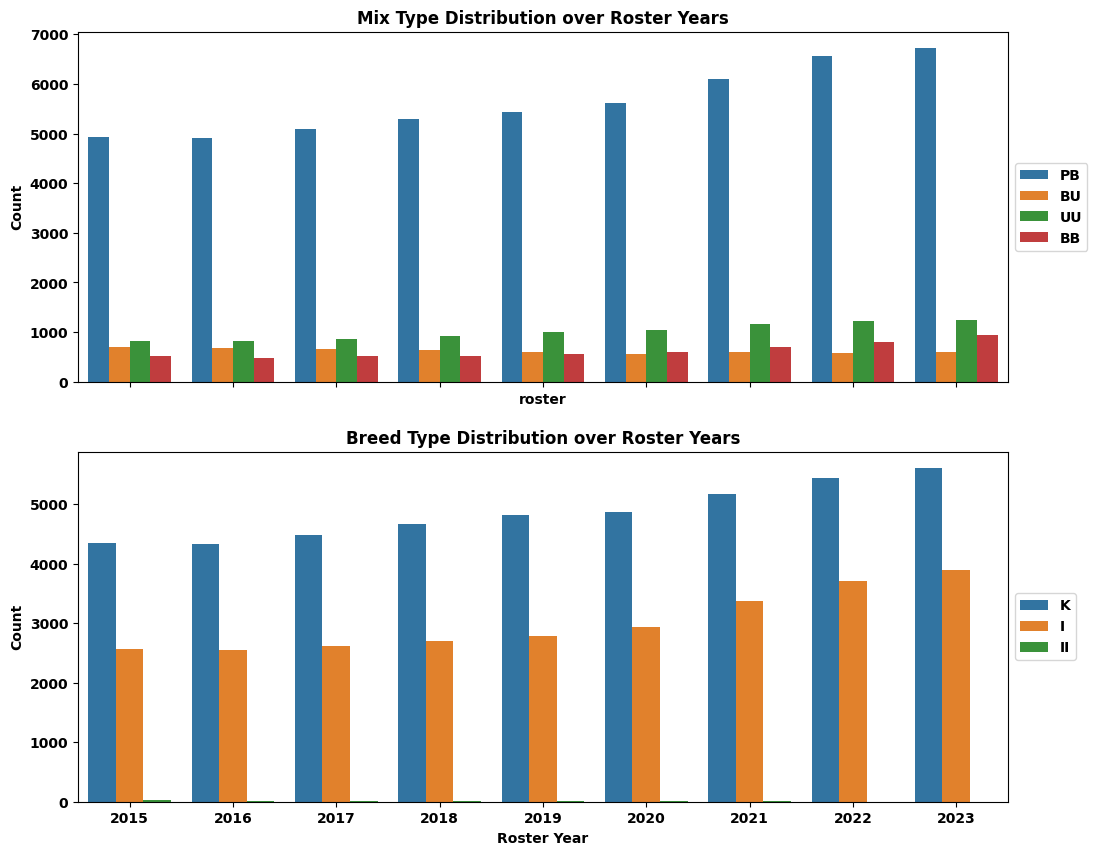

In [34]:
from matplotlib import pyplot as plt

# Set the style for the plots
# sns.set(style="whitegrid")


# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot for Mix Type over Roster Years
sns.countplot(x="roster", hue="mixed_type", data=dog_data, ax=axes[0])
axes[0].set_title("Mix Type Distribution over Roster Years")
axes[0].set_ylabel("Count")
axes[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot for Breed Type over Roster Years
sns.countplot(x="roster", hue="breed_type", data=dog_data, ax=axes[1])
axes[1].set_title("Breed Type Distribution over Roster Years")
axes[1].set_xlabel("Roster Year")
axes[1].set_ylabel("Count")
axes[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
# Display the plots
plt.show()

Here we see that there is a strong upward tick in the number of dog owners for 30 and 40 year-old. Up until 2019 it was the 50 year olds that had the highest number of dog owners This is a trend that we will explore further in this analysis.

In [35]:
highlighted_age_groups = [30, 40]
dog_owner_grouped_count = (
    dog_data.groupby(["roster", "age_group_10"]
                     ).size().reset_index(name="count")
)


def get_hv_plot(data, x, group_by, highlight_list, **kwargs):
    """Function to get a plot for each age group"""
    plots = []
    colors = kwargs.get("colors", ["lightgray"])
    highlight_colors = kwargs.get("highlight_colors", ["crimson"])

    for i, age_group in enumerate(data[group_by].unique()):
        # Filter the DataFrame for the specified age group
        filtered_data = data.query(f"{group_by} == @age_group")

        # Determine the color for the plot
        plot_color = (
            highlight_colors[i % len(highlight_colors)]
            if age_group in highlight_list
            else colors[i % len(colors)]
        )

        # Create a line plot for the specified age group
        line_plot = filtered_data.hvplot(
            color=plot_color, x=x, by=group_by, alpha=0.8)

        # Create a scatter plot for the specified age group
        scatter_plot = filtered_data.hvplot.scatter(
            color=plot_color, x=x, y="count", by=group_by
        )

        # Combine the line plot and scatter plot
        plot = line_plot * scatter_plot
        plots.append(plot)

    # Overlay the plots
    combined_plot = hv.Overlay(plots)

    return combined_plot


plot = get_hv_plot(
    dog_owner_grouped_count,
    "roster",
    "age_group_10",
    highlighted_age_groups,
    highlight_colors=[
        "#3274a1",
        "#e1812c",
    ],
)
plot.opts(
    title="30- and 40-year-old Owners Contribute to increase in Dog Ownership",
    ylabel="Count",
    height=500,
    width=800,
)

:Overlay
   .NdOverlay.I     :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.II    :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.III   :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.IV    :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.V     :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.VI    :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.VII   :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.VIII  :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.IX    :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.X     :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.XI    :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.XII   :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.XIII  :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.XIV   :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.XV    :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.XVI   :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.XVII  :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.XVIII :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)
   .NdOverlay.XIX   :NdOverlay   [age_group_10]
      :Curve   [roster]   (count)
   .NdOverlay.XX    :NdOverlay   [age_group_10]
      :Scatter   [roster]   (count)

This is a simple wordcloud taken from a Print description of the district. When you click on the district as well as the word cloud comes up in the shape of the district. The description that the word cloud is formed from is also shown in a pane.

In [36]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=districts_poly)


def display_info(index):
    if not index:
        return pn.pane.Markdown("No district selected on Here")
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        return pn.pane.Markdown(
            f"""
            ## <span style='color: #008080;'>{dnum}</span>
            # <span style='color: #000080;'>{dname}</span>
            ### <span style='color: #708090;'>{ddesc}</span>
                    """,
            width=500,
            styles={
                "border": "2px solid #4a4a4a",
                "border-radius": "10px",
                "padding": "20px",
                "background-color": "#f9f9f9",
                "box-shadow": "0 4px 8px 0 rgba(0,0,0,0.2)",
            },
        )


def display_wordcloud(index):
    # breed_color = explicit_mapping[breed]
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud))
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = districts_poly.iloc[index[0]].data["geometry"].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        width = maxx - minx
        height = maxy - miny

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new("1", (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test) * 255,
            # color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            # contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            # toolbar=None,
        )


layout = pn.Column(
    pn.bind(display_wordcloud, select_district.param.index),
    pn.Row(
        districts_poly * neighborhood_poly,
        pn.bind(display_info, select_district.param.index),
    ),
)

breed_chloro_card = pn.Card(
    layout,
    title="District Descript",
    sizing_mode="stretch_width",
)
# breed_chloro_card

In [37]:
pn.state.kill_all_servers()
breed_chloro_card

BokehModel(combine_events=True, render_bundle={'docs_json': {'547367ca-707c-4cb6-8d86-428dc25da7a4': {'version…

Popular Breeds


In [38]:
# the top n small breeds in Zurich
ktopn = (
    dog_data.loc[dog_data["breed_type"] == "K"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
ktopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "K") & (dog_data["is_pure_breed"])]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

# The top n big breeds in Zurich
itopn = (
    dog_data[dog_data["breed_type"] == "I"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)
itopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "I") & (dog_data["is_pure_breed"])]
    .standard.value_counts()
    .head(15)
    .index.tolist()
)

topn = ktopn + itopn
topn_pure = ktopn_pure + itopn_pure

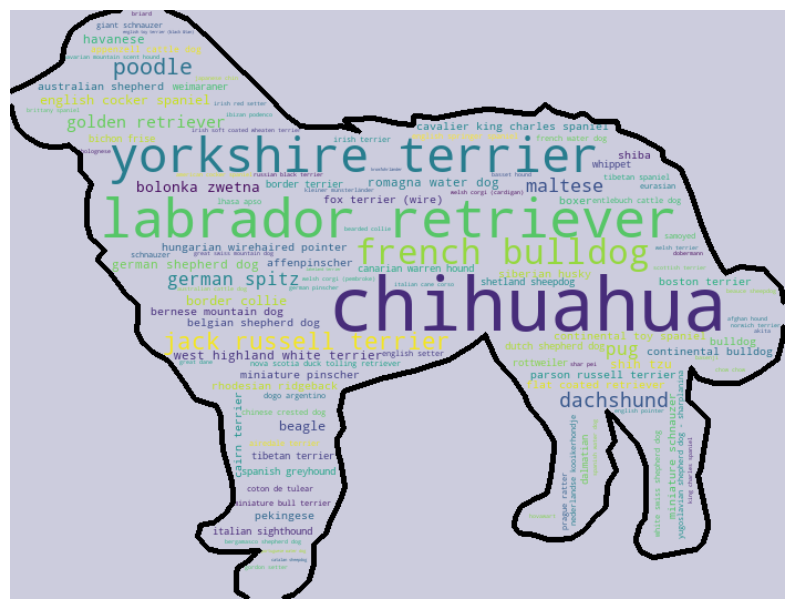

In [39]:
mask_path = "../images/wordcloud_mask.jpg"
dog_mask = np.array(Image.open(mask_path))
# Threshold to remove the gray watermark
threshold = 150
dog_mask[dog_mask < threshold] = 0
dog_mask[dog_mask >= threshold] = 255

# Create a count of the various pure breeds
pure_breed_count = dog_data.loc[(
    dog_data["is_pure_breed"])].standard.value_counts()
# Create a word cloud for the pure breeds
wordcloud = WordCloud(
    contour_width=5,
    background_color="#ccd",
    mask=dog_mask,
).generate_from_frequencies(pure_breed_count)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
dog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70941 entries, 0 to 70940
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_male_owner         70941 non-null  bool   
 1   is_male_dog           70941 non-null  bool   
 2   age_group_10          70941 non-null  float64
 3   dog_age               70941 non-null  float64
 4   district              70941 non-null  float64
 5   sub_district          70941 non-null  float64
 6   breed_type            70941 non-null  object 
 7   roster                70941 non-null  int64  
 8   is_pure_breed         70941 non-null  bool   
 9   breed_1               70941 non-null  object 
 10  breed_2               70941 non-null  object 
 11  neighborhood          70941 non-null  string 
 12  dog_color             70941 non-null  object 
 13  owner_id              70941 non-null  object 
 14  dog_count             70941 non-null  int64  
 15  is_mixed_breed     

In [41]:
dog_data.sample().T

,55741
is_male_owner,True
is_male_dog,False
age_group_10,70.0
dog_age,14.0
district,11.0
sub_district,119.0
breed_type,K
roster,2019
is_pure_breed,False
breed_1,unbekannt


#### Zurich Population Dataset
Number of economic resident population by statistical urban district, origin, sex, age year, 5-year age groups and year, since 1993.



In [42]:
# zurich_pop_link = "https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv"
zurich_pop_link = "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_pop.csv"
zurich_pop_data = pd.read_csv(zurich_pop_link)
zurich_pop_data = hf.sanitize_df_column_names(zurich_pop_data)
zurich_pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   deadline_date_year  370658 non-null  int64 
 1   age_v_sort          370658 non-null  int64 
 2   age_v_cd            370658 non-null  int64 
 3   age_v_short         370658 non-null  int64 
 4   age_v_05_sort       370658 non-null  int64 
 5   age_v_05_cd         370658 non-null  int64 
 6   age_v_05_short      370658 non-null  object
 7   age_v_10_cd         370658 non-null  int64 
 8   age_v_10_short      370658 non-null  object
 9   age_v_20_cd         370658 non-null  int64 
 10  age_v_20_short      370658 non-null  object
 11  sex_cd              370658 non-null  int64 
 12  sex_long            370658 non-null  object
 13  sex_short           370658 non-null  object
 14  circle_cd           370658 non-null  int64 
 15  circle_lang         370658 non-null  object
 16  qu

In [43]:
zurich_pop_data.sample().T

,211156
deadline_date_year,2010
age_v_sort,25
age_v_cd,25
age_v_short,25
age_v_05_sort,6
age_v_05_cd,25
age_v_05_short,25-29
age_v_10_cd,20
age_v_10_short,20-29
age_v_20_cd,20


In [44]:
zurich_pop_data["is_swiss"] = zurich_pop_data["origin_lang"].str.contains(
    "Schweizer", regex=False, na=False, case=False
)
zurich_pop_data["neighborhood"] = zurich_pop_data["quar_lang"].copy()
zurich_pop_data["district"] = zurich_pop_data["circle_cd"].copy().astype(int)
zurich_pop_data["sub_district"] = (
    zurich_pop_data["quar_cd"].copy().astype(str).str.zfill(3)
)
zurich_pop_data["roster"] = zurich_pop_data["deadline_date_year"].copy()
zurich_pop_data["age_group_10"] = zurich_pop_data["age_v_10_cd"].copy()
zurich_pop_data["age"] = zurich_pop_data["age_v_cd"].copy()
zurich_pop_data["is_male"] = zurich_pop_data["sex_cd"] == 1
zurich_pop_data["pop_count"] = zurich_pop_data["number_we"].copy()

columns_of_interest_pop = [
    "is_swiss",
    "neighborhood",
    "district",
    "sub_district",
    "roster",
    "age_group_10",
    "age",
    "is_male",
    "pop_count",
]

pop_data = zurich_pop_data[columns_of_interest_pop].copy()
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_swiss      370658 non-null  bool  
 1   neighborhood  370658 non-null  object
 2   district      370658 non-null  int32 
 3   sub_district  370658 non-null  object
 4   roster        370658 non-null  int64 
 5   age_group_10  370658 non-null  int64 
 6   age           370658 non-null  int64 
 7   is_male       370658 non-null  bool  
 8   pop_count     370658 non-null  int64 
dtypes: bool(2), int32(1), int64(4), object(2)
memory usage: 19.1+ MB


We need to ensure That there were datasets have some of the same column and column names so that they could be merged together and matched well. Since we only have data from the year 2015 with adults data set we will only look at data from the year 2015 with the population data set. And to match the age range that we have in the dogs data set we will also take the ages in the 10 year range here in addition to that the ado is also given on at the neighborhood level so that can be easily matched as well.


In [45]:
pop_data.sample().T

,36257
is_swiss,True
neighborhood,Langstrasse
district,4
sub_district,042
roster,1995
age_group_10,90
age,96
is_male,True
pop_count,1


Let's look at some descriptive statistics on the data first.Here we see that the data is pretty clean already there are only 30 four neighborhoods and sub districts there are 12 districts come on the Rasta who is from 1993 to 2022 however we would only use from 2015. We will aggregate the data for the ages so that it matches the range that we had in the dog data set so that our direct comparison can be made.

In [46]:
# Description of the data
pop_data.describe(include="all").T.sort_values(by="unique")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_swiss,370658,2,True,199628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_male,370658,2,False,188476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,370658,34,Sihlfeld,11605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_district,370658,34,034,11605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district,370658.0,NaN,NaN,NaN,6.382215,3.532491,1.0,3.0,7.0,9.0,12.0
roster,370658.0,NaN,NaN,NaN,2007.617618,8.661926,1993.0,2000.0,2008.0,2015.0,2022.0
age_group_10,370658.0,NaN,NaN,NaN,42.102963,27.348304,0.0,20.0,40.0,60.0,100.0
age,370658.0,NaN,NaN,NaN,46.516676,27.357132,0.0,23.0,46.0,69.0,111.0
pop_count,370658.0,NaN,NaN,NaN,31.333286,32.840995,0.0,7.0,21.0,44.0,255.0


In [47]:
pop_data.loc[pop_data["roster"] >= 2015]
post_2015_pop_data = pop_data.loc[pop_data["roster"] >= 2015].copy()

# group by age group , roster, subdistrict, is_male and sum the population count
pop_data_agg = (
    post_2015_pop_data.groupby(
        ["roster", "sub_district", "is_male", "age_group_10", "neighborhood"]
    )["pop_count"]
    .sum()
    .reset_index()
)
# quick sanity check to see if the sum is what we believe the population of Zurich is
pop_data_agg.groupby("roster")["pop_count"].sum()

roster
2015    410404
2016    415682
2017    423310
2018    428737
2019    434008
2020    434736
2021    436332
2022    443037
Name: pop_count, dtype: int64

In [48]:
# Get the unique age groups from the dog data
dog_age_groups = dog_data.age_group_10.unique()

# Filter the population data to only include these age groups
pop_data_filtered = pop_data_agg[pop_data_agg.age_group_10.isin(
    dog_age_groups)]
pop_data_filtered

,roster,sub_district,is_male,age_group_10,neighborhood,pop_count
1,2015,011,False,10,Rathaus,58
2,2015,011,False,20,Rathaus,310
3,2015,011,False,30,Rathaus,304
4,2015,011,False,40,Rathaus,196
5,2015,011,False,50,Rathaus,186
...,...,...,...,...,...,...
5756,2022,123,True,50,Hirzenbach,748
5757,2022,123,True,60,Hirzenbach,514
5758,2022,123,True,70,Hirzenbach,334
5759,2022,123,True,80,Hirzenbach,193


In [49]:
# Do a aggregation of the pop data on the roster level and on the is_male level and sum the population count
pop_data_agg = (
    pop_data_filtered.groupby(["roster", "is_male"])[
        "pop_count"].sum().unstack()
)

# Normalize the population count to calculate the percentage portion
pop_data_agg_normalized = pop_data_agg.div(pop_data_agg.sum(axis=1), axis=0)

pop_data_agg_normalized.round(3)

is_male,False,True
roster,,
2015,0.504,0.496
2016,0.503,0.497
2017,0.502,0.498
2018,0.501,0.499
2019,0.501,0.499
2020,0.501,0.499
2021,0.500,0.500
2022,0.499,0.501


We see that they're just about equal amounts of men and women male and female persons in Zurich this is interesting because the dog owners ratio but significantly higher for females than for males.

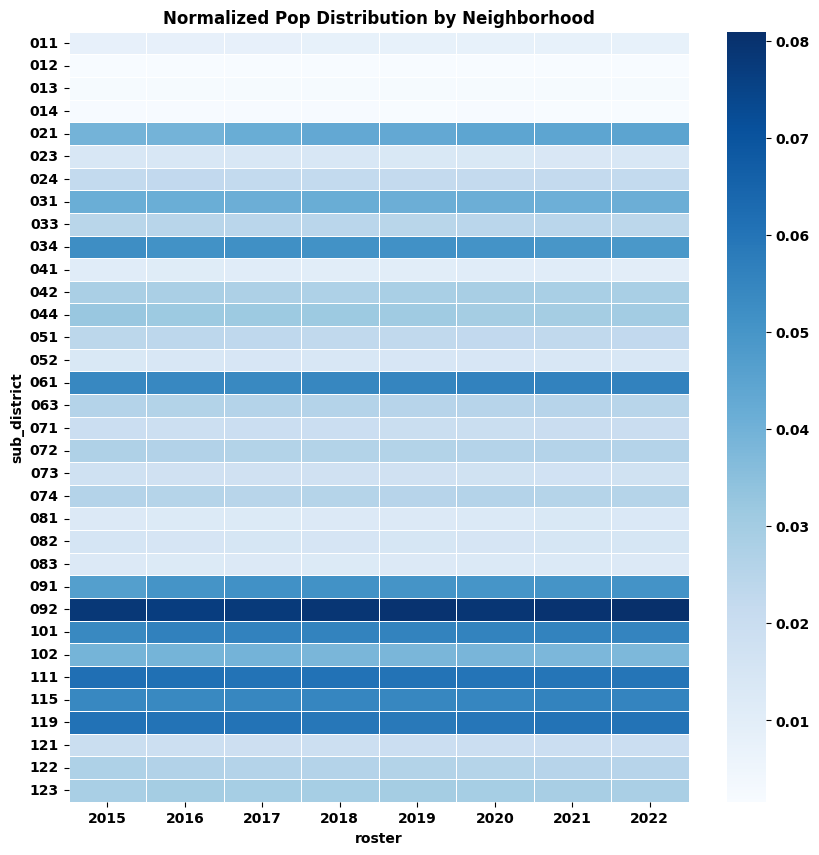

In [50]:
# Do a sum per roster and per neighborhood and display graphically
pop_data_sub_district_agg = (
    pop_data_filtered.groupby(["roster", "sub_district"])[
        "pop_count"].sum().unstack()
)
pop_data_sub_district_normalized = pop_data_sub_district_agg.div(
    pop_data_sub_district_agg.sum(axis=1), axis=0
)
plt.figure(figsize=(10, 10))
# Create the heatmap
heatmap = sns.heatmap(
    pop_data_sub_district_normalized.T,
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
    cbar=True,
    linewidths=0.5,
    linecolor="white",
)

# Rotate the x-axis labels
plt.xticks(rotation=0)
# Rotate the y-axis labels
plt.yticks(rotation=0)
plt.title("Normalized Pop Distribution by Neighborhood")

plt.show()

The heat map shows that the proportion of the population within each of the neighborhoods in Zurich stayed approximately the same throughout the years from 2015 to 2022.

In [51]:
pop_data_filtered.groupby(["roster", "sub_district"], as_index=False)[
    "pop_count"].sum()



pop_data_filtered


@pn.depends(roster_slider.param.value)
def get_pop_neighborhood_count(roster):


    df = pop_data_filtered.query(f"roster=={roster}")


    df = df.groupby("neighborhood")["pop_count"].sum()

    map_gdf = neighborhood_gdf.set_index("neighborhood")

    agg_gdf = map_gdf.merge(df, left_index=True, right_index=True, how="left")


    return gv.Polygons(agg_gdf).opts(


        **poly_opts,


        color="pop_count",


        colorbar=True,


        tools=["hover", "tap", "box_select"],


        title=f"Pop Count {roster}",


        aspect="equal",


    )


@pn.depends(roster_slider.param.value)
def get_pop_density(roster):


    df = pop_data_filtered.query(f"roster=={roster}")


    df = df.groupby("neighborhood")["pop_count"].sum()

    map_gdf = merged_gdf.set_index("neighborhood")

    agg_gdf = map_gdf.merge(df, left_index=True, right_index=True, how="left")


    agg_gdf["pop_density"] = agg_gdf["pop_count"] / agg_gdf["area_km2"]


    return gv.Polygons(agg_gdf).opts(


        **poly_opts,


        color="pop_density",


        colorbar=True,


        tools=["hover", "tap", "box_select"],


        title=f"Pop Density {roster}",


        aspect="equal",


    )


pop_count_pane = pn.pane.HoloViews(get_pop_neighborhood_count)


pop_density_pane = pn.pane.HoloViews(get_pop_density)


pn.Column(roster_slider, pn.Row(pop_count_pane, pop_density_pane))

BokehModel(combine_events=True, render_bundle={'docs_json': {'e4d0eba3-c831-4d2f-9856-ae4f7c0033b6': {'version…

In [52]:
pop_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 1 to 5760
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   roster        4895 non-null   int64 
 1   sub_district  4895 non-null   object
 2   is_male       4895 non-null   bool  
 3   age_group_10  4895 non-null   int64 
 4   neighborhood  4895 non-null   object
 5   pop_count     4895 non-null   int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 234.2+ KB


In [53]:
pop_data_filtered.sample().T

,927
roster,2016
sub_district,034
is_male,True
age_group_10,70
neighborhood,Sihlfeld
pop_count,393


In [54]:
pop_data.loc[pop_data["roster"] == 2022].head(50)
pop_data.age.value_counts()

24     4074
25     4072
27     4072
26     4071
28     4071
       ... 
107      13
108       5
109       3
110       1
111       1
Name: age, Length: 112, dtype: int64

#### Zurich Income Dataset
These data contain quantile values of the taxable income of natural persons who are primarily taxable in the city of Zurich. Tax income are in thousand francs (integer).

In [55]:
# zurich_income_link = "https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv"
zurich_income_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_income.csv"
)
zurich_income_data = pd.read_csv(zurich_income_link)
zurich_income_data.info()
zurich_income_data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   StichtagDatJahr      2244 non-null   int64  
 1   QuarSort             2244 non-null   int64  
 2   QuarCd               2244 non-null   int64  
 3   QuarLang             2244 non-null   object 
 4   SteuerTarifSort      2244 non-null   int64  
 5   SteuerTarifCd        2244 non-null   int64  
 6   SteuerTarifLang      2244 non-null   object 
 7   SteuerEinkommen_p50  2181 non-null   float64
 8   SteuerEinkommen_p25  2181 non-null   float64
 9   SteuerEinkommen_p75  2181 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 175.4+ KB


Index(['StichtagDatJahr', 'QuarSort', 'QuarCd', 'QuarLang', 'SteuerTarifSort',
       'SteuerTarifCd', 'SteuerTarifLang', 'SteuerEinkommen_p50',
       'SteuerEinkommen_p25', 'SteuerEinkommen_p75'],
      dtype='object')

In [56]:
zurich_income_data = hf.sanitize_df_column_names(zurich_income_data)
zurich_income_data.info()
zurich_income_data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   deadline_date_year  2244 non-null   int64  
 1   quar_sort           2244 non-null   int64  
 2   quar_cd             2244 non-null   int64  
 3   quar_lang           2244 non-null   object 
 4   tax_tariff_sort     2244 non-null   int64  
 5   tax_tariff_cd       2244 non-null   int64  
 6   tax_tariff_long     2244 non-null   object 
 7   tax_income_p_50     2181 non-null   float64
 8   tax_income_p_25     2181 non-null   float64
 9   tax_income_p_75     2181 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 175.4+ KB


Index(['deadline_date_year', 'quar_sort', 'quar_cd', 'quar_lang',
       'tax_tariff_sort', 'tax_tariff_cd', 'tax_tariff_long',
       'tax_income_p_50', 'tax_income_p_25', 'tax_income_p_75'],
      dtype='object')

In [57]:
zurich_income_data

,deadline_date_year,quar_sort,quar_cd,quar_lang,tax_tariff_sort,tax_tariff_cd,tax_tariff_long,tax_income_p_50,tax_income_p_25,tax_income_p_75
0,1999,11,11,Rathaus,0,0,Grundtarif,39.90,18.7,65.20
1,1999,11,11,Rathaus,1,1,Verheiratetentarif,80.40,48.1,128.00
2,1999,11,11,Rathaus,2,2,Einelternfamilientarif,44.60,25.0,87.50
3,1999,12,12,Hochschulen,0,0,Grundtarif,31.05,12.4,55.20
4,1999,12,12,Hochschulen,1,1,Verheiratetentarif,89.20,52.0,178.70
...,...,...,...,...,...,...,...,...,...,...
2239,2020,122,122,Schwamendingen-Mitte,1,1,Verheiratetentarif,62.85,39.7,89.15
2240,2020,122,122,Schwamendingen-Mitte,2,2,Einelternfamilientarif,30.90,14.6,52.30
2241,2020,123,123,Hirzenbach,0,0,Grundtarif,33.50,13.5,52.30
2242,2020,123,123,Hirzenbach,1,1,Verheiratetentarif,64.45,40.6,88.00


In [58]:
tax_tariff_long_de = zurich_income_data.tax_tariff_long.unique().tolist()
tax_tariff_long_translated = translate_list_to_dict(tax_tariff_long_de)
display(tax_tariff_long_translated)
zurich_income_data["tax_status"] = zurich_income_data.tax_tariff_long.map(
    tax_tariff_long_translated
)
# Create the neighborhood, roster, district, sub_district columns
zurich_income_data["neighborhood"] = zurich_income_data["quar_lang"].copy()
zurich_income_data["roster"] = zurich_income_data["deadline_date_year"].copy()
zurich_income_data["sub_district"] = (
    zurich_income_data["quar_cd"].copy().astype(str).str.zfill(3)
)
zurich_income_data["district"] = (
    zurich_income_data["sub_district"].str[:2].astype(int).copy()
)
zurich_income_data["median_income"] = zurich_income_data["tax_income_p_50"].copy()
zurich_income_data["lower_q_income"] = zurich_income_data["tax_income_p_25"].copy()
zurich_income_data["upper_q_income"] = zurich_income_data["tax_income_p_75"].copy()

columns_of_interest_income = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "tax_status",
    "median_income",
    "lower_q_income",
    "upper_q_income",
]
# create a dataframe with only the columns of interest
income_data = zurich_income_data[columns_of_interest_income].copy()
income_data.info()

{'Grundtarif': 'Basic tariff',
 'Verheiratetentarif': 'Married rate',
 'Einelternfamilientarif': 'Single-parent family tariff'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   neighborhood    2244 non-null   object 
 1   roster          2244 non-null   int64  
 2   district        2244 non-null   int32  
 3   sub_district    2244 non-null   object 
 4   tax_status      2244 non-null   object 
 5   median_income   2181 non-null   float64
 6   lower_q_income  2181 non-null   float64
 7   upper_q_income  2181 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 131.6+ KB


In [59]:
income_data.sample().T
income_data.tax_status.unique()

array(['Basic tariff', 'Married rate', 'Single-parent family tariff'],
      dtype=object)

In [60]:
income_data.loc[income_data["median_income"].isna()]

,neighborhood,roster,district,sub_district,tax_status,median_income,lower_q_income,upper_q_income
5,Hochschulen,1999,1,012,Single-parent family tariff,NaN,NaN,NaN
8,Lindenhof,1999,1,013,Single-parent family tariff,NaN,NaN,NaN
11,City,1999,1,014,Single-parent family tariff,NaN,NaN,NaN
107,Hochschulen,2000,1,012,Single-parent family tariff,NaN,NaN,NaN
110,Lindenhof,2000,1,013,Single-parent family tariff,NaN,NaN,NaN
113,City,2000,1,014,Single-parent family tariff,NaN,NaN,NaN
209,Hochschulen,2001,1,012,Single-parent family tariff,NaN,NaN,NaN
212,Lindenhof,2001,1,013,Single-parent family tariff,NaN,NaN,NaN
215,City,2001,1,014,Single-parent family tariff,NaN,NaN,NaN
311,Hochschulen,2002,1,012,Single-parent family tariff,NaN,NaN,NaN


#### Zurich Household Dataset
Number of private households as well as the economic population of the city of Zurich in private households by household size, urban district, statistical urban district and year, since 2013.

A household includes all persons who live together in the same apartment. For this purpose, the term "economic residence" is used for persons. Collective households (homes, hospitals, penal institutions, communal accommodation for asylum seekers, etc.) are not taken into account.

In [61]:
zurich_household_data_link = "https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv"
zurich_household_data_link = (
    "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_household.csv"
)
zurich_household_data = pd.read_csv(zurich_household_data_link)
zurich_household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   StichTagDatJahr  2040 non-null   int64 
 1   QuarSort         2040 non-null   int64 
 2   QuarLang         2040 non-null   object
 3   KreisSort        2040 non-null   int64 
 4   KreisLang        2040 non-null   object
 5   hh_groesseSort   2040 non-null   int64 
 6   hh_groesseLang   2040 non-null   object
 7   AnzHH            2040 non-null   int64 
 8   AnzBestWir       2040 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 143.6+ KB


In [62]:
zurich_household_data = hf.sanitize_df_column_names(zurich_household_data)
zurich_household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   key_day_dat_year  2040 non-null   int64 
 1   quar_sort         2040 non-null   int64 
 2   quar_lang         2040 non-null   object
 3   circle_sort       2040 non-null   int64 
 4   circle_lang       2040 non-null   object
 5   hh_size_sort      2040 non-null   int64 
 6   hh_size_lang      2040 non-null   object
 7   number_hh         2040 non-null   int64 
 8   number_we         2040 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 143.6+ KB


In [63]:
zurich_household_data

,key_day_dat_year,quar_sort,quar_lang,circle_sort,circle_lang,hh_size_sort,hh_size_lang,number_hh,number_we
0,2013,11,Rathaus,1,Kreis 1,1,1 Person,1146,1146
1,2013,11,Rathaus,1,Kreis 1,2,2 Personen,472,944
2,2013,11,Rathaus,1,Kreis 1,3,3 Personen,138,414
3,2013,11,Rathaus,1,Kreis 1,4,4 Personen,67,268
4,2013,11,Rathaus,1,Kreis 1,5,5 Personen,27,135
...,...,...,...,...,...,...,...,...,...
2035,2022,123,Hirzenbach,12,Kreis 12,2,2 Personen,1625,3250
2036,2022,123,Hirzenbach,12,Kreis 12,3,3 Personen,824,2472
2037,2022,123,Hirzenbach,12,Kreis 12,4,4 Personen,711,2844
2038,2022,123,Hirzenbach,12,Kreis 12,5,5 Personen,212,1060


In [64]:
zurich_household_data["neighborhood"] = zurich_household_data["quar_lang"].copy()
zurich_household_data["roster"] = zurich_household_data["key_day_dat_year"].copy()
zurich_household_data["sub_district"] = (
    zurich_household_data["quar_sort"].copy().astype(str).str.zfill(3)
)
zurich_household_data["district"] = (
    zurich_household_data["sub_district"].str[:2].astype(int).copy()
)
zurich_household_data["household_size"] = (
    zurich_household_data["hh_size_sort"].copy().astype(str).str.zfill(2)
)
zurich_household_data["household_count"] = zurich_household_data["number_hh"].copy()
zurich_household_data["resident_count"] = zurich_household_data["number_we"].copy()

# create a dataframe with only the columns of interest
columns_of_interest_household = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "household_size",
    "household_count",
    "resident_count",
]
household_data = zurich_household_data[columns_of_interest_household].copy()

household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   neighborhood     2040 non-null   object
 1   roster           2040 non-null   int64 
 2   district         2040 non-null   int32 
 3   sub_district     2040 non-null   object
 4   household_size   2040 non-null   object
 5   household_count  2040 non-null   int64 
 6   resident_count   2040 non-null   int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 103.7+ KB


In [65]:
household_data.sample().T

,1125
neighborhood,Fluntern
roster,2018
district,7
sub_district,071
household_size,04
household_count,388
resident_count,1552


In [66]:
household_data.loc[
    (household_data["sub_district"] == "013") & (
        household_data["roster"] == 2022)
]["resident_count"].sum()

1015

In [67]:
household_data["household_size"].unique()

array(['01', '02', '03', '04', '05', '06'], dtype=object)

In [68]:
pop_data.loc[(pop_data["sub_district"] == "013") & (pop_data["roster"] == 2022)][
    "pop_count"
].sum()

1034

In [69]:
dog_data["age_group_10"] = pd.Categorical(
    dog_data["age_group_10"], ordered=True)


dog_data["age_group_10"].cat.categories


dog_data["roster"] = dog_data["roster"].astype(str)


dog_data["roster"] = pd.Categorical(dog_data["roster"], ordered=True)



dog_data["roster"].cat.categories

Index(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], dtype='object')

In [70]:
ktopn = (
    dog_data.loc[dog_data["breed_type"] == "K"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)

ktopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "K") & (dog_data["is_pure_breed"])][
        "standard"
    ]
    .value_counts()
    .head(15)
    .index.tolist()
)

itopn = (
    dog_data.loc[dog_data["breed_type"] == "I"]["standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)

itopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "I") & (dog_data["is_pure_breed"])][
        "standard"
    ]
    .value_counts()
    .head(15)
    .index.tolist()
)
topn = ktopn + itopn
topn_pure = ktopn_pure + itopn_pure

In [71]:
dog_data.sample()
zurich_income_data.loc[zurich_income_data["roster"] > 2014][
    ["tax_status", "tax_income_p_50", "district", "sub_district", "roster"]
]
tax_status_button = pnw.RadioButtonGroup(
    name="Tax Status",
    options=list(zurich_income_data["tax_status"].unique()),
    value="Basic tariff",
    button_style="outline",
    button_type="success",
)
roster_button = pnw.RadioButtonGroup(
    value=2018,
    options=list(range(2015, 2021)),
    button_style="outline",
    button_type="success",
)


@pn.depends(roster_button.param.value, tax_status_button.param.value)
def get_income_polygon(roster, tax_status):
    df = zurich_income_data.loc[
        (zurich_income_data["roster"] == roster)
        & (zurich_income_data["tax_status"] == tax_status)
    ][["roster", "tax_status", "tax_income_p_50", "sub_district"]]

    income_gdf = neighborhood_gdf.merge(df, on="sub_district")
    # income_gdf = income_gdf.drop(columns=["km2"])

    income_cmap = list(sns.color_palette(
        "light:" + "#008800", n_colors=6).as_hex())
    return gv.Polygons(income_gdf).opts(
        **poly_opts,
        color="tax_income_p_50",
        # fill_alpha=0,
        cmap=income_cmap,
        clim=(30, 100),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{tax_status.title()} | {roster}",
    )


income_chloropleth = pn.pane.HoloViews(get_income_polygon)

pn.Column(tax_status_button, roster_button, get_income_polygon).show()

Launching server at http://localhost:51428


In [72]:
neighborhood_gdf

,neighborhood,sub_district,district,geometry
0,Hirslanden,073,7,"POLYGON ((8.55670 47.36407, 8.55670 47.36406, ..."
1,Weinegg,083,8,"POLYGON ((8.55671 47.36405, 8.55670 47.36405, ..."
2,Mühlebach,082,8,"POLYGON ((8.55423 47.36456, 8.55422 47.36458, ..."
3,Seefeld,081,8,"POLYGON ((8.54795 47.36500, 8.54781 47.36501, ..."
4,Werd,041,4,"POLYGON ((8.53301 47.37394, 8.53310 47.37405, ..."
5,Sihlfeld,034,3,"POLYGON ((8.51937 47.37478, 8.51931 47.37488, ..."
6,Albisrieden,091,9,"POLYGON ((8.50127 47.37961, 8.50177 47.37996, ..."
7,Hottingen,072,7,"POLYGON ((8.58346 47.38831, 8.58317 47.38830, ..."
8,Wollishofen,021,2,"POLYGON ((8.54297 47.33543, 8.55388 47.34086, ..."
9,Unterstrass,061,6,"POLYGON ((8.52688 47.40709, 8.52717 47.40668, ..."


In [73]:
unique_breeds = dog_data["standard"].unique()
num_unique_breeds = len(unique_breeds)

# Repeat the colormap to cover all unique breeds
repeated_cmap = list(cc.glasbey_dark) * \
    (num_unique_breeds // len(cc.glasbey_dark) + 1)

# Explicit mapping for the color to use for each standard breed
explicit_mapping = {breed: repeated_cmap[i]
                    for i, breed in enumerate(unique_breeds)}
my_colors = hv.Cycle(list(explicit_mapping.values()))


# colormaps for the the gender
boy_cmap = list(sns.color_palette("light:#00008b", n_colors=6).as_hex())


girl_cmap = list(sns.color_palette("light:#8b008b", n_colors=6).as_hex())

In [74]:

neighborhood_gdf["km2"] = neighborhood_gdf.to_crs(
    ccrs.GOOGLE_MERCATOR).area / 10**6
neighborhood_gdf["km2"] = neighborhood_gdf["km2"].round(2)
districts_gdf["km2"] = districts_gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6
districts_gdf["km2"] = districts_gdf["km2"].round(2)
districts_gdf

,district,geometry,km2
0,1,"POLYGON ((8.54195 47.37971, 8.54196 47.37972, ...",3.92
1,2,"POLYGON ((8.51982 47.32401, 8.51974 47.32401, ...",24.09
2,3,"POLYGON ((8.51943 47.35125, 8.51889 47.35111, ...",18.84
3,4,"POLYGON ((8.53301 47.37394, 8.53299 47.37392, ...",6.33
4,5,"POLYGON ((8.52834 47.38939, 8.52862 47.38919, ...",4.35
5,6,"POLYGON ((8.54797 47.39915, 8.54801 47.39918, ...",11.12
6,7,"POLYGON ((8.60185 47.37186, 8.60188 47.37178, ...",32.72
7,8,"POLYGON ((8.56493 47.34636, 8.56458 47.34619, ...",10.47
8,9,"POLYGON ((8.50127 47.37961, 8.50121 47.37957, ...",26.28
9,10,"POLYGON ((8.52545 47.40667, 8.52574 47.40675, ...",19.82


In [75]:
hv.opts.defaults(
    hv.opts.HeatMap(
        tools=["hover", "tap", "box_select"],
        active_tools=["box_zoom"],
        width=800,
        height=500,
        ylabel="",
        line_color="white",
        line_width=2,
        toolbar="above",
        selection_line_color="red",
        nonselection_alpha=0.9,
        nonselection_line_color="white",
    )
)

poly_opts = dict(
    width=800,
    height=500,
    line_width=2,
    xaxis=None,
    yaxis=None,
    aspect="equal",
    # cmap=explicit_mapping,
    # projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=500,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",
    xlabel="",
    cmap=explicit_mapping,
    show_legend=False,
    active_tools=["box_zoom"],
)

In [76]:
tools_opts = dict(active_tools=["box_zoom"], toolbar="above")
# bar plot of the owner age distribution
owner_age_groups_all = (
    dog_data.groupby(["age_group_10", "roster"])
    .size()
    .unstack()
    .rename(columns={0: "Count"})
    .hvplot.bar(
        xlabel="",
        rot=90,
        legend=True,
        tools=["hover", "box_select"],
        title="Owners Age distribution",
        muted_line_alpha=0.01,
    )
    .opts(**tools_opts)
)
# kde plot of the dog age distribution
dog_age_all = dog_data.hvplot.kde(
    y="dog_age",
    by="roster",
    xlim=(0, 21),
    ylim=(0, 0.1),
    xlabel="",
    legend=True,
    tools=["hover", "box_select"],
    title="Dog Age Density distribution",
    muted_alpha=0.01,
).opts(**tools_opts)
# step plot of the dog age distribution
dog_age_all_step = (
    dog_data.groupby(["dog_age", "roster"])
    .size()
    .hvplot.step(
        x="dog_age",
        by="roster",
        xlim=(0, 21),
        title="Dog Age distribution",
    )
    .opts(**tools_opts)
)
# panel card with the 3 plots
all_ages_card = pn.Card(
    # add spacer
    pn.Spacer(height=70),
    dog_age_all_step,
    dog_age_all,
    owner_age_groups_all,
    title="Age Distribution for ALL Dogs and Owners",
    styles={"background": "gainsboro"},
)

In [77]:
pn.state.kill_all_servers()
all_ages_card.show()

Launching server at http://localhost:51443


In [78]:
def plot_age_range_stats(df, breed, bw, is_pure_breed):
    """Function to plot the age_range stats for the breed owners and the dog age distribution"""
    if is_pure_breed:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False) & is_pure_breed == True'
        )
    else:
        breed_df = df.query(
            f'standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    # plot a step plot of the dog_age
    step = (
        breed_df.groupby(["dog_age", "roster"])
        .size()
        .unstack()
        .hvplot.step(
            title=f"Dog Age distribution | {breed.title()}",
            shared_axes=False,
            muted_alpha=0.1,
        )
    )

    # plot age_range of breed_df kde plot
    kde = breed_df.hvplot.kde(
        y="dog_age",
        by="roster",
        bandwidth=bw,
        xlim=(0, 20),
        ylim=(0, None),
        xlabel="",
        muted_alpha=0.01,
        title=f"Dog Age density distribution | {breed.title()}",
    )
    # plot age_range of breed_df bar plot

    bar = (
        breed_df.groupby(["age_group_10", "roster"])
        .size()
        .unstack()
        .hvplot.bar(
            rot=90,
            legend=True,
            tools=["hover", "box_select"],
            title=f"Owner Age distribution | {breed.title()} ",
            shared_axes=False,
            xlabel="",
        )
        .opts(active_tools=["box_select"])
    )
    return (step + kde + bar).cols(1)


# create widgets for the breed, bandwidth
breed_selector = pnw.Select(name="Breed", options=topn, value="french bulldog")
top_n_slider = pnw.IntSlider(
    name="Top N", start=1, end=30, step=1, value=10, width=200)
bandwidth_slider = pnw.FloatSlider(
    name="Bandwidth", start=0.1, end=2, step=0.1, value=0.5, width=200
)
pure_breed_checkbox = pnw.Checkbox(name="Pure Breed", value=True, width=200)
is_male_owner_checkbox = pnw.Checkbox(
    name="Male Dog Owner", value=True, width=200)
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017", "2018",
             "2019", "2020", "2021", "2022", "2023"],
    name="Roster",
    width=200,
)
show_labels_checkbox = pnw.Checkbox(
    name="Show Annotations", value=True, width=200)


# create a dynamic map

dynamic_age_plot = pn.bind(
    plot_age_range_stats,
    df=dog_data,
    breed=breed_selector,
    bw=bandwidth_slider,
    is_pure_breed=pure_breed_checkbox,
)
widget_controls = pn.Row(
    pure_breed_checkbox,
    breed_selector,
    bandwidth_slider,
    styles={"background": "mintcream"},
)
dynamic_age_card = pn.Card(
    widget_controls,
    dynamic_age_plot,
    title="Age Distribution of Dog and Owners by Breeds",
    styles={"background": "mintcream"},
)

In [79]:
# pn.Column(dynamic_age_card).show()
districts_gdf = districts_gdf.dissolve(by="district")
districts_gdf
# dog_data
# dynamic_age_card

,geometry,km2
district,,
1,"POLYGON ((8.54195 47.37971, 8.54196 47.37972, ...",3.92
2,"POLYGON ((8.51982 47.32401, 8.51974 47.32401, ...",24.09
3,"POLYGON ((8.51943 47.35125, 8.51889 47.35111, ...",18.84
4,"POLYGON ((8.53301 47.37394, 8.53299 47.37392, ...",6.33
5,"POLYGON ((8.52834 47.38939, 8.52862 47.38919, ...",4.35
6,"POLYGON ((8.54797 47.39915, 8.54801 47.39918, ...",11.12
7,"POLYGON ((8.60185 47.37186, 8.60188 47.37178, ...",32.72
8,"POLYGON ((8.56493 47.34636, 8.56458 47.34619, ...",10.47
9,"POLYGON ((8.50127 47.37961, 8.50121 47.37957, ...",26.28


In [80]:
pn.state.kill_all_servers()


# get the count of the french bulldog in each district for each roster and plot it
# plot it on a dynamic map with a slider for the roster
def get_breed_count(breed, roster):
    df = dog_data[
        (dog_data["standard"] == breed)
        & (dog_data["roster"].str.contains(roster))
    ][["district", "standard", "roster"]]
    df = df.groupby("district").size().reset_index(name="count")
    df = df.set_index("district")

    breed_gdf = districts_gdf.merge(
        df, left_index=True, right_index=True, how="left")
    # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
    breed_color = explicit_mapping[breed]
    # Start from white and go to the breed color
    breed_cmap = list(sns.color_palette(
        "light:" + breed_color, n_colors=6).as_hex())
    return gv.Polygons(breed_gdf).opts(
        **poly_opts,
        color="count",
        # fill_alpha=0,
        cmap=breed_cmap,
        clim=(0, 50),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{breed.title()} | {roster}",
    )


standard_selecter = pnw.Select(
    name="Breed", options=topn, value="french bulldog")
# create the dynamic map
breed_chloro = gv.DynamicMap(
    pn.bind(get_breed_count, breed=breed_selector, roster=roster_slider)
)

In [81]:
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")
pn.Column(standard_selecter, pn.Row(roster_slider, breed_chloro))
# breed_chloro

BokehModel(combine_events=True, render_bundle={'docs_json': {'cc84c89e-6a47-4855-b5b6-97f0137126f9': {'version…

In [82]:
pn.state.kill_all_servers()


# poly_opts = dict(
#     width=800,
#     height=800,
#     line_width=2,
#     color_index=None,
#     xaxis=None,
#     yaxis=None,
# )

neighborhood_poly = gv.Polygons(neighborhood_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="crimson",
    # fill_color="lightgray",
    # fill_alpha=0,
    alpha=0.2,
)
neighborhood_poly

pn.pane.HoloViews(breed_chloro).show()

Launching server at http://localhost:51455


In [83]:
neighborhood_poly.data
breed_chloro.data

{(): :Polygons   [Longitude,Latitude]   (km2,count)}

In [84]:
districts_gdf = (
    neighborhood_gdf.dissolve(by="district")
    .drop(columns=["neighborhood", "sub_district"])
    .reset_index()
)

districts_poly = gv.Polygons(districts_gdf).opts(
    **poly_opts,
    color_index=None,
)

# (district_poly * neighborhood_poly).opts(title="Zurich Districts and Neighborhoods")

In [85]:
zurich_desc_path = "../data/zurich_districts.csv"
zurich_desc = pd.read_csv(zurich_desc_path)
# zurich_desc["district"] = zurich_desc["district"].astype(str).str.zfill(2)
districts_gdf["district"] = districts_gdf["district"].astype(int)

districts_gdf = districts_gdf.merge(
    zurich_desc[["district", "desc", "district_name"]], on="district", how="left"
)
# districts_gdf.set_index("district", inplace=True)
districts_poly = gv.Polygons(districts_gdf)

In [86]:
districts_gdf = districts_gdf.dissolve(by="district")
districts_poly = gv.Polygons(districts_gdf)

districts_gdf
districts_poly.data

,geometry,km2,desc,district_name
district,,,,
1,"POLYGON ((8.54195 47.37971, 8.54196 47.37972, ...",0.58,The most central district encompasses the hist...,"Old Town, City Center"
2,"POLYGON ((8.51982 47.32401, 8.51974 47.32401, ...",12.58,The architecturally attractive Enge Train Stat...,Left Shore of the Lake
3,"POLYGON ((8.51943 47.35125, 8.51889 47.35111, ...",3.62,"Once mainly a working-class neighborhood, the ...",Creative Quarter of Wiedikon
4,"POLYGON ((8.53301 47.37394, 8.53299 47.37392, ...",0.67,The district around Langstrasse was long regar...,Creative Quarter of Langstrasse
5,"POLYGON ((8.52834 47.38939, 8.52862 47.38919, ...",1.62,In the quarter where huge machines once clatte...,Creative Quarter of Zürich-West
6,"POLYGON ((8.54797 47.39915, 8.54801 47.39918, ...",5.38,"University buildings, Jugendstil villas, green...",University Quarter
7,"POLYGON ((8.60185 47.37186, 8.60188 47.37178, ...",4.76,"The hillside location, little traffic, and fab...",On the Zürichberg
8,"POLYGON ((8.56493 47.34636, 8.56458 47.34619, ...",3.80,This district starts behind the Opera House an...,Right Shore of the Lake
9,"POLYGON ((8.50127 47.37961, 8.50121 47.37957, ...",10.03,"For a long time, this district was solely know...",At the Foot of the Uetliberg


In [87]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=districts_poly)


def display_info(index):
    if not index:
        return pn.pane.Markdown("No district selected")
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        return pn.pane.Markdown(
            f"#### {dnum}\n ### {dname}\n {ddesc}",
        )


def display_wordcloud(index, breed):
    breed_color = explicit_mapping[breed]
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud))
    else:
        selected_district = (
            districts_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = districts_poly.iloc[index[0]].data["geometry"].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        width = maxx - minx
        height = maxy - miny

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new("1", (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test) * 255,
            color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            # toolbar=None,
        )


layout = pn.Column(
    pn.bind(display_wordcloud, select_district.param.index, breed=breed_selector),
    districts_poly * breed_chloro,
    pn.bind(display_info, select_district.param.index),
    width=800,
)

breed_chloro_card = pn.Card(
    roster_slider, layout, title="Chloropleth of Selected Breed"
)

In [88]:
dynamic_age_card

BokehModel(combine_events=True, render_bundle={'docs_json': {'cf2785a1-bb18-4f32-8c39-045f186d775d': {'version…

In [89]:
pn.Row(
    dynamic_age_card,
    breed_chloro_card,
    all_ages_card,
    sizing_mode="stretch_width",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'6faa5557-a329-4b84-a75e-9d5bcadcfcc3': {'version…

Gender Heatmap


In [90]:
# Create a Tap stream linked to the HeatMap
breed_tap = streams.Tap(source=None)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_gender_roster_df(roster, gender):
    return dog_data.loc[
        (dog_data["is_male_owner"] == gender) & (dog_data["roster"] == roster)
    ]


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_top_n_gender_breeds(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    return (
        gender_roster_df["standard"].value_counts().head(
            top_n).index.tolist()
    )


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_gender_heatmap(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    topn_gender_breeds = get_top_n_gender_breeds(
        roster=roster, gender=gender, top_n=top_n
    )

    top_gender_breeds_df = (
        gender_roster_df.loc[
            gender_roster_df["standard"].isin(topn_gender_breeds)
        ]
        .groupby(["standard", "district"])
        .size()
        .fillna(0)
        .reset_index(name="count")
    )
    sex = "Male" if gender else "Female"
    top_gender_breeds_heatmap = hv.HeatMap(
        top_gender_breeds_df, ["district", "standard"], "count"
    ).redim(standard="gender_standard")
    top_gender_breeds_heatmap.opts(
        height=(33 * top_n) + 50,
        cmap=boy_cmap if gender else girl_cmap,
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top {top_n} breeds | {roster} | {sex} Owners",
        clim=(0, 50),
    )
    breed_tap.source = top_gender_breeds_heatmap

    return top_gender_breeds_heatmap


dynamic_gender_heatmap_panel = pn.pane.HoloViews(get_gender_heatmap)

# pn.Column(
#     roster_slider,
#     holder_gender_checkbox,
#     top_n_slider,
#     dynamic_gender_heatmap_panel,
# ).show()

In [91]:
@pn.depends(
    breed_tap.param.x,
    breed_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def get_breed_chloropleth(x, y, roster, gender):
    if x is None or y is None:
        return gv.Polygons(districts_gdf).opts(**poly_opts, title="Select a cell")
    else:
        data = get_gender_roster_df(roster=roster, gender=gender)
        data = data.loc[data["standard"] == y]
        data = data.groupby("district").size().reset_index(name="count")
        data = data.set_index("district")

        breed_gdf = districts_gdf.merge(
            data, left_index=True, right_index=True, how="left"
        )
        # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
        breed_gdf.fillna(0, inplace=True)
        breed_color = explicit_mapping[y]
        breed_cmap = list(
            sns.color_palette("light:" + breed_color, n_colors=6).as_hex()
        )
        sex = "Male" if gender else "Female"

        return gv.Polygons(breed_gdf).opts(
            **poly_opts,
            color="count",
            cmap=breed_cmap,
            clim=(0, 50),
            colorbar=True,
            line_color="darkgray",
            tools=["hover", "tap", "box_select"],
            title=f"{y.title()} | {roster} | {sex} Owners",
        )


breed_chloropleth = pn.pane.HoloViews(get_breed_chloropleth)


# Combine the heatmap and the text display into a layout
layout = pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    top_n_slider,
    dynamic_gender_heatmap_panel,
    breed_chloropleth,
)

# layout.show()

In [92]:
# Define a Tap stream linked to the owner age group
owner_tap = streams.Tap(source=None, x=1, y=30)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_age_heatmap(roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    data_grouped = (
        data.groupby(["district", "age_group_10"])["owner_id"]
        .nunique()
        .reset_index()
        .rename(columns={"owner_id": "count"})
    )
    sex = "Male" if gender else "Female"
    heatmap = hv.HeatMap(data_grouped, ["district", "age_group_10"], "count")

    heatmap.opts(
        # **heatmap_opts,
        cmap=boy_cmap if gender else girl_cmap,
        ylim=(0, 100),
        xlim=(0, 12),
        colorbar=True,
        active_tools=["box_zoom"],
        tools=["hover", "tap", "box_select"],
        title=f"{sex} Dog Owners | {roster} | by Age Group vs District",
    )
    owner_tap.source = heatmap
    return heatmap


age_group_panel = pn.pane.HoloViews(get_age_heatmap)

In [93]:
dog_data["age_group_10"].cat.categories

Float64Index([-1.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0], dtype='float64')

In [94]:
import math

pn.state.kill_all_servers()
# Bar Plot which shows the top 10 breeds for each district and age group as it is selected in the heatmap

bar_plots_opts = dict(
    height=500,
    width=800,
    invert_axes=True,
    cmap=explicit_mapping,
    show_legend=False,
    xlabel="",
    fontscale=1.2,
)


@pn.depends(
    owner_tap.param.x,
    owner_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def update_barplot(x, y, roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    if x is None or y is None:
        bar_data = (
            data["standard"]
            .value_counts()
            .head(10)
            .rename("count")
            .reset_index()
            .rename(columns={"index": "standard"})
        )
        return hv.Bars(bar_data, kdims=["standard"], vdims="count").opts(
            **bar_plots_opts,
            color="standard",
            title=f"Top 10 Breeds",
            tools=["hover"],
            active_tools=["box_zoom"],
        )
    x = math.ceil(x - 0.5)
    y = math.ceil(y / 10) * 10
    bar_data = (
        data.loc[(data["district"] == x) & (
            data["age_group_10"] == y)]["standard"]
        .value_counts()
        .head(10)
        .reset_index()
    )
    bar_data.columns = ["standard", "count"]
    if len(bar_data) == 0:
        return hv.Bars([], "standard", "count").opts(
            **bar_plots_opts,
            title=f"No Breeds for Age-group:{y} | Districts:{x}",
            active_tools=["box_zoom"],
        )

    return hv.Bars(bar_data, "standard", "count").opts(
        **bar_plots_opts,
        color="standard",
        title=f"Top {min(10,len(bar_data))} Popular Breeds | Age-group:{y} | Districts:{x}",
    )


update_barplot_panel = pn.pane.HoloViews(update_barplot)
pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    age_group_panel,
    update_barplot_panel,
).show()

Launching server at http://localhost:51467


In [95]:
dog_data

,is_male_owner,is_male_dog,age_group_10,dog_age,district,sub_district,breed_type,roster,is_pure_breed,breed_1,breed_2,neighborhood,dog_color,owner_id,dog_count,is_mixed_breed,mixed_type,dog_color_en,breed_1_en,breed_2_en,breed_de,standard,breed_de_2,standard_2,age_group_10_missing
0,True,False,60.0,3.0,9.0,92.0,K,2015,True,welsh terrier,keine,Altstetten,schwarz/braun,000126,1,False,PB,black/brown,welsh terrier,no,welsh terrier,welsh terrier,keine,none,0
1,False,False,70.0,10.0,7.0,71.0,K,2015,True,welsh terrier,keine,Fluntern,black/tan,084431,1,False,PB,black/tan,welsh terrier,no,welsh terrier,welsh terrier,keine,none,0
2,False,True,40.0,15.0,7.0,74.0,K,2015,True,welsh terrier,keine,Witikon,schwarz/rot,088455,1,False,PB,black red,welsh terrier,no,welsh terrier,welsh terrier,keine,none,0
3,False,True,40.0,4.0,8.0,82.0,K,2015,True,welsh terrier,keine,Mühlebach,braun/schwarz,101835,1,False,PB,Brown black,welsh terrier,no,welsh terrier,welsh terrier,keine,none,0
4,True,False,60.0,4.0,3.0,31.0,K,2015,True,welsh terrier,keine,Alt-Wiedikon,black/tan,108769,1,False,PB,black/tan,welsh terrier,no,welsh terrier,welsh terrier,keine,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70936,False,True,30.0,2.0,9.0,91.0,I,2022,False,pyrenäenberghund,brandlbracke,Albisrieden,weiss/schwarz/braun,159827,1,True,BB,white/black/brown,Pyrenees mountain dog,brandlbracke,pyrenäenberghund,pyrenean mountain dog,brandlbracke,austrian black and tan hound,0
70937,False,True,30.0,3.0,9.0,91.0,I,2023,False,pyrenäenberghund,brandlbracke,Albisrieden,weiss/schwarz/braun,159827,1,True,BB,white/black/brown,Pyrenees mountain dog,brandlbracke,pyrenäenberghund,pyrenean mountain dog,brandlbracke,austrian black and tan hound,0
70938,False,True,30.0,1.0,10.0,101.0,I,2023,False,english pointer,ca de bestiar (spanischer schäferhund),Höngg,dunkelbraun,162139,1,True,BB,dark brown,English pointer,ca de bestiar (Spanish sheepdog),english pointer,english pointer,ca de bestiar (spanischer schäferhund),majorca shepherd dog,0
70939,True,True,50.0,4.0,2.0,23.0,I,2022,False,ciobanesc romanesc carpatin,kaukasischer schäfer,Leimbach,grau/weiss/schwarz,081586,1,True,BB,grey/white/black,ciobanesc romanesc carpatin,caucasian shepherd,ciobanesc romanesc carpatin,romanian carpathian shepherd dog,kaukasischer schäfer,caucasian shepherd dog,0
